# Molecular dynamics application example

## Pre-requirements

### Import dependencies

In [1]:
# Primary imports
import gc
import importlib     # Only needed for module editing
import json
import pandas as pd  # Optional dependency
from pathlib import Path
import pickle
import pprint
import sys
import time
import warnings
warnings.simplefilter("ignore")  # Surpress or enable warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets  # For sklearn test data set creation
from sklearn.preprocessing import StandardScaler

# CNN clustering module
import cnnclustering.cnn as cnn    # CNN clustering
import cnnclustering.cmsm as cmsm  # Core-set MSM estimation
import pydpc

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Aug 21 2020, 18:21:27) 
[GCC 7.5.0]


### Notebook configuration

We use `matplotlib` to create plots. A `"matplotlibrc"` file can be used to customise the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

### Package configuration

In [5]:
# Configuration file found?
cnn.settings.cfgfile  # If None, no file is provided

In [6]:
# Display default settings
cnn.settings.defaults

{'default_cnn_cutoff': '1',
 'default_cnn_offset': '0',
 'default_radius_cutoff': '1',
 'default_member_cutoff': '2',
 'default_fit_policy': 'conservative',
 'default_predict_policy': 'conservative',
 'float_precision': 'sp',
 'int_precision': 'sp'}

## Helper functions

In [7]:
def draw_evaluate(clusterobject, axis_labels=False, plot="dots"):
    fig, Ax = plt.subplots(
        1, 3,
        figsize=(mpl.rcParams['figure.figsize'][0],
                 mpl.rcParams['figure.figsize'][1]*0.5)
        )

    for dim in range(3):
        dim_ = (dim * 2, dim * 2 + 1)
        
        ax_props_ = {k: v for k, v in ax_props.items()}
        if axis_labels:
            ax_props_.update({"xlabel": dim_[0] + 1, "ylabel": dim_[1] + 1})

        _ = clusterobject.evaluate(
            ax=Ax[dim], plot=plot,
            ax_props=ax_props_,
            dim=dim_
            )

## MD showcase - Langerin

Let's read in some "real world" data for this example. We will work with a 6D projection of a classical MD trajectory of the C-type lectin receptor langerin that was generated by the dimension reduction procedure TICA.

In [128]:
langerin = cnn.CNN(points=np.load("md_example/md_showcase_langerin.npy", allow_pickle=True))

After creating a `CNN` instance, we can print out basic information about the data. The projection comes in 116 parts of individual independent simulations. The number of data points in these parts is written out for the first 4 parts. In total we have about 2.6 million data points in this set representing 26 microseconds of simulation time at a sampling timestep of 10 picoseconds.

In [9]:
print(langerin)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 116, [5571  4148  20851  99928 ...]
                                Points     - 2641593
                                Dimensions - 6

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



Dealing with six data dimensions we can still visualise the data quite well.

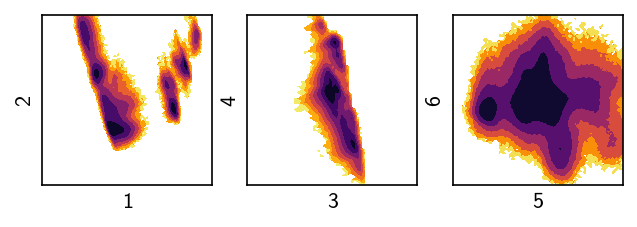

In [10]:
draw_evaluate(langerin, axis_labels=True, plot="contourf")

Clustering of this fairly large amount of data points directly is in principle possible, but it will be slow. Pre-calculating pairwise distances would occupy terabytes of disk space which we can not afford and so we have resort to brute-force on-the-fly distance calculation. To allow quick and handy data exploration and cluster result screening we want to work on a reduced data set.

In [11]:
langerin_reduced = langerin.cut(points=(None, None, 100))

Now we distance pre-calculation is feasible and clustering will be much faster. When reducing a data set it is most important that the new set remains representative of the original one. Usually using a regular stride on the data points will be appropriate.

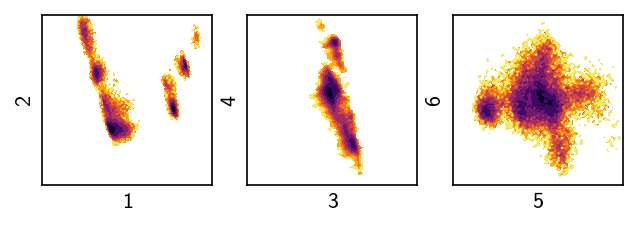

In [12]:
draw_evaluate(langerin_reduced, axis_labels=True, plot="contourf")

In [13]:
print(langerin_reduced)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 116, [56  42  209  1000 ...]
                                Points     - 26528
                                Dimensions - 6

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



A quick look on the distribution of distances in the set gives us a first feeling for what might be a suitable value for the neighbour search radius *r*. By the way, if data points are sliced regularly and the reduced set is representative of the original, the overall distribution of pairwise distances is not effected much by the absolute number of points in the set.

Mapping: 100%|██████████| 11.0/11.0 [00:05<00:00, 2.03Chunks/s]
Mapping: 100%|██████████| 11.0/11.0 [00:05<00:00, 1.90Chunks/s]
Mapping: 100%|██████████| 11.0/11.0 [00:05<00:00, 2.16Chunks/s]
Mapping: 100%|██████████| 11.0/11.0 [00:05<00:00, 2.08Chunks/s]


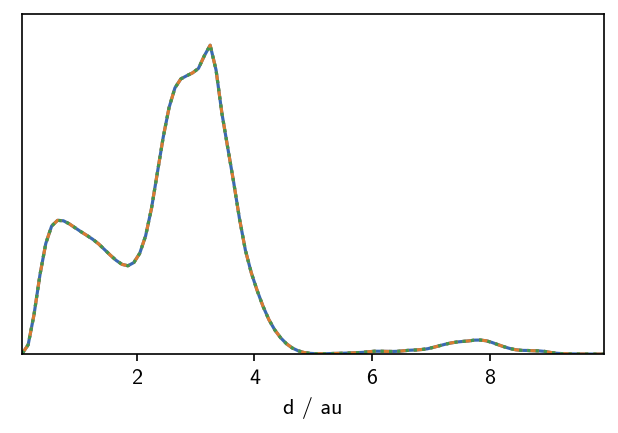

In [15]:
linestyles = ["solid", "dashed", "dotted"]

fig, ax = plt.subplots()
for linestyle, red in zip(linestyles, [10, 500, 2000]):
    langerin_reduced = langerin.cut(points=(None, None, 100))
    langerin_reduced.calc_dist(mmap=True, chunksize=2500)
    # Pre-calculate point distances and temporary store on disk
    
    langerin_reduced.dist_hist(ax=ax,
                               plot_props={"linestyle": linestyle})
    
    # Free memory
    %xdel langerin_reduced  
    gc.collect()
    
langerin_reduced = langerin.cut(points=(None, None, 100))
langerin_reduced.calc_dist(mmap=True, chunksize=2500)

In [53]:
langerin_reduced = langerin.cut(points=(None, None, 100))
langerin_reduced.calc_dist(mmap=True, chunksize=2000)

Mapping: 100%|██████████| 14.0/14.0 [00:16<00:00, 1.19s/Chunks]


We can expect a split of the data into clusters for values of *r* of roughly 2 or lower. The maximum in the distribution closest to 0 defines a reasonable value range for $r$. We can also get a feeling for what values *c* could take by checking the number of neighbours each point has for a given search radius.

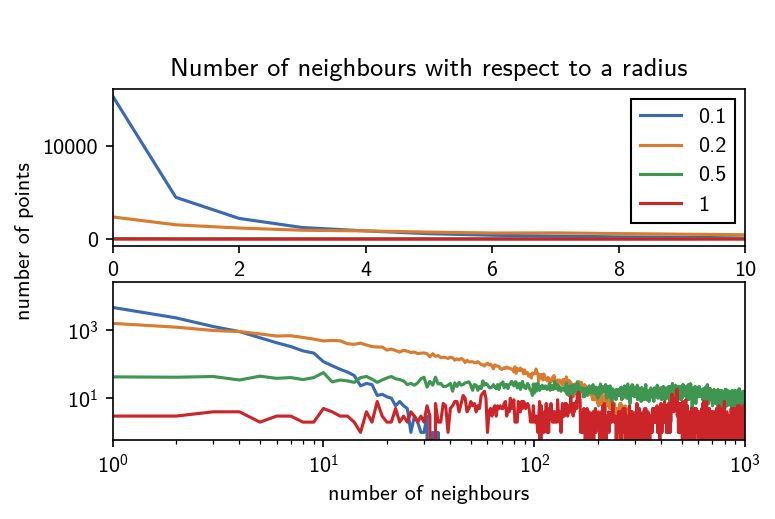

In [54]:
range_ = (-0.5, 1000.5)
bins_ = len(range(int(range_[0] + 0.5), int(range_[1] - 0.5))) + 1
fig, ax = plt.subplots(2, 1)
radii = [0.1, 0.2, 0.5, 1]
for radius in radii:
    langerin_reduced.calc_neighbours_from_dist(radius)
    H, e = np.histogram(langerin_reduced.data.neighbourhoods.n_neighbours,
                        bins = bins_,
                        range=range_)
    e = (e[:-1] + e[1:]) / 2
    ax[0].plot(e, H)
    ax[1].plot(e, H)

ax[0].set(**{
    "title": "Number of neighbours with respect to a radius",
    "xlim": (range_[0] + 0.5, (range_[1] - 0.5) / 100),
    "ylabel": "number of points                    "
    })
ax[1].set(**{
    "xlim": (1, range_[1] - 0.5),
    "xscale": "log",
    "yscale": "log",
    "xlabel": "number of neighbours"
    })

ax[0].legend([0.1, 0.2, 0.5, 1], fancybox=False, framealpha=1, edgecolor="k")

fig.tight_layout(pad=0.1)

In the radius value regime of 1 and lower the number of neighbours per point quickly approaches the order of number of points in the whole data set. We can look at these plots as an upper bound for *c* if *r* gets lower. Values of *c* larger than 100 wont make sense for radii below 0.2. We can also see that for a radius 0.1, approximately one third of the data points has no neighbour at all. 

### Clustering root data

Let's attempt a first clustering step with a relatively low density criterion (large *r* cutoff, low number of common neighbours *c*). When we cluster, we can judge the outcome by how many clusters we obtain and how many points end up as being classified as noise. For the first clustering steps, it can be a good idea to start with a low density cutoff and then increase it gradually. As we choose higher density criteria the number of resulting clusters will rise and so will the noise level. We need to find the point where we yield a large number of (reasonably sized) clusters without loosing relevant information in the noise. Keep in mind that the ideal number of clusters and noise ratio are not definable and highly dependend on the nature of the data:

Execution time for call of fit: 0 hours, 0 minutes, 23.0126 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26528     2.000     5         2         None      3         0.983     0.000     
--------------------------------------------------------------------------------


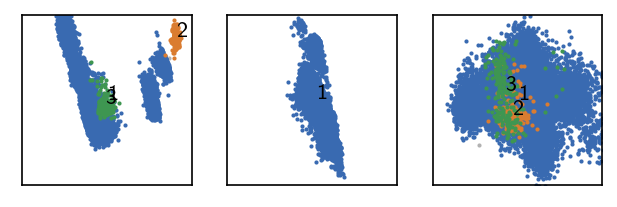

In [52]:
langerin_reduced.fit(2, 5, policy="progressive")
draw_evaluate(langerin_reduced)

Low number of clusters and no noise points. We can push this a bit further.

Execution time for call of fit: 0 hours, 0 minutes, 3.4059 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26528     1.000     5         2         None      5         0.714     0.001     
--------------------------------------------------------------------------------


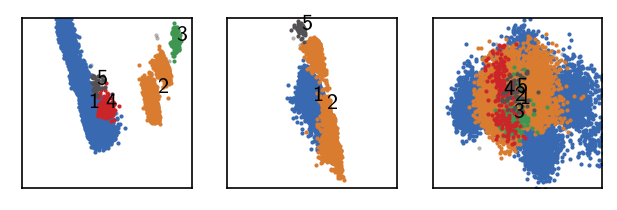

In [85]:
langerin_reduced.fit(1, 5, policy="progressive")
draw_evaluate(langerin_reduced)

Two more clusters and still little noise. There is room for more. At this point we choose a `member_cutoff` of 10 for the fit, ensuring that we do not yield very small, meaningless clusters.

Execution time for call of fit: 0 hours, 0 minutes, 7.4663 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26528     0.500     5         10        None      7         0.710     0.011     
--------------------------------------------------------------------------------


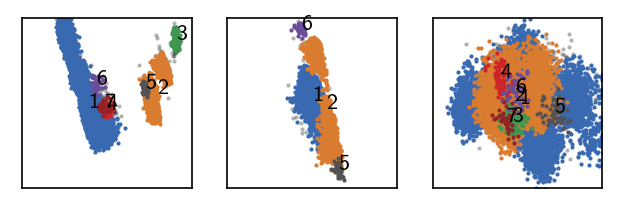

In [54]:
langerin_reduced.fit(0.5, 5, policy="progressive", member_cutoff=10)
draw_evaluate(langerin_reduced)

This looks good so far. There is no point in going any further at this stage. If we reduce *r* even more, we begin to loose clusters again into noise:

Execution time for call of fit: 0 hours, 0 minutes, 2.9209 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26528     0.400     5         10        None      9         0.681     0.029     
--------------------------------------------------------------------------------


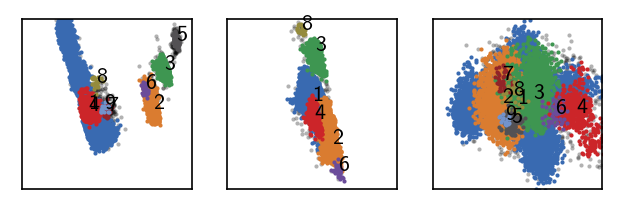

In [83]:
langerin_reduced.fit(0.4, 5, policy="progressive", member_cutoff=10)
draw_evaluate(langerin_reduced)

### Clustering hierarchy level 1

We saw that parts of the data could be splitted further, but that increasing the density criterion leads to possible loss of relevant information in other data areas. Especially the first cluster can obviously be splitted further. Let' recluster it applying a higher density criterion. For this we first need to freeze this cluster result and isolate the obtained clusters into individual child cluster objects.

In [55]:
# Lets make sure we work on the correctly clustered object
print("Label", "r", "c", sep="\t")
print("-" * 20)
for k, v in sorted(langerin_reduced.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	c
--------------------
1	0.5	5
2	0.5	5
3	0.5	5
4	0.5	5
5	0.5	5
6	0.5	5
7	0.5	5


In [56]:
# Freeze this cluster result
langerin_reduced.isolate()
current = c1 = langerin_reduced.children[1]

By default, the isolation assigns an alias to each child cluster that reveals its origin. In this case "root - 1", translates to the first child cluster of the root data.

In [30]:
current

CNN clustering object (root - 1)

We now cluster the first child cluster from this current cluster result with increased density criteria.

Execution time for call of fit: 0 hours, 0 minutes, 0.3149 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
18839     0.400     10        10        None      3         0.946     0.029     
--------------------------------------------------------------------------------


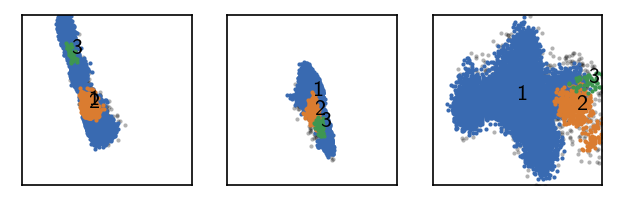

In [57]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.4
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 10, member_cutoff=10)
draw_evaluate(current)

Good ...

Execution time for call of fit: 0 hours, 0 minutes, 0.4437 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
18839     0.375     10        10        None      5         0.825     0.041     
--------------------------------------------------------------------------------


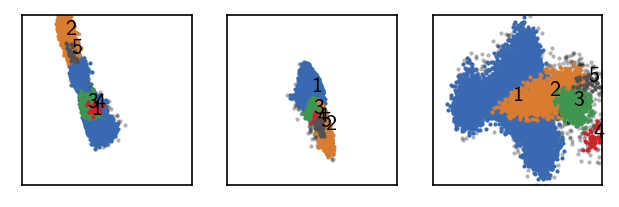

In [58]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.375
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 10, member_cutoff=10)
draw_evaluate(current)

Better ...

Execution time for call of fit: 0 hours, 0 minutes, 0.3362 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
18796     0.300     10        10        None      5         0.776     0.112     
--------------------------------------------------------------------------------


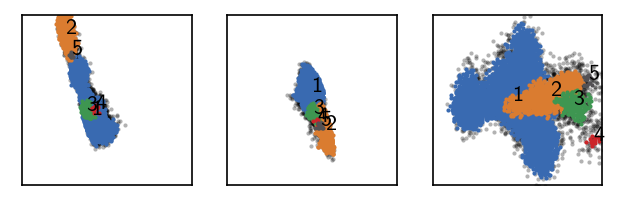

In [98]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.3
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 10, member_cutoff=10)
draw_evaluate(current)

Probably to much! Let's keep the second last try.

We can also work on the second cluster of the first split.

In [59]:
current = c2 = langerin_reduced.children[2]

Execution time for call of fit: 0 hours, 0 minutes, 0.0591 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
6993      0.400     5         10        None      2         0.615     0.013     
--------------------------------------------------------------------------------


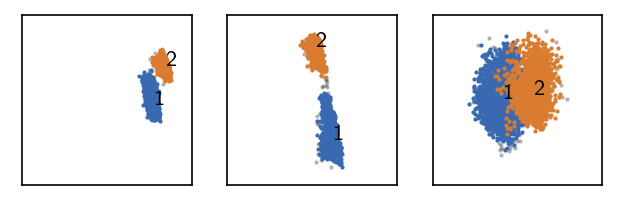

In [60]:
# Recluster second cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.4
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 5, member_cutoff=10)
draw_evaluate(current)

### Clustering hierarchy level 2

The re-clustered data points still may be clustered further.

In [61]:
current = c1

In [62]:
# Lets make sure we work on the correctly clustered object
print("Label", "r", "c", sep="\t")
print("-" * 20)
for k, v in sorted(current.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	c
--------------------
1	0.375	10
2	0.375	10
3	0.375	10
4	0.375	10
5	0.375	10


In [33]:
current

CNN clustering object (root - 1)

In [63]:
current.isolate()
current = c1_1 = current.children[1]

In [64]:
current

CNN clustering object (root - 1 - 1)

Execution time for call of fit: 0 hours, 0 minutes, 16.5692 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
15541     0.250     15        10        None      3         0.589     0.237     
--------------------------------------------------------------------------------


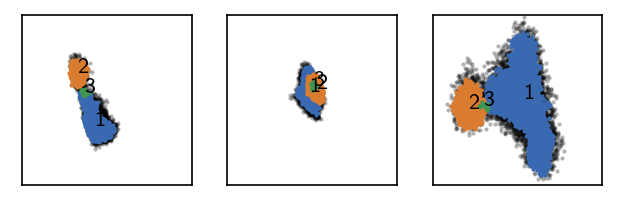

In [65]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.25
# current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 15, member_cutoff=10)
draw_evaluate(current)

### Clustering hierarchy level 3

And on it goes ...

In [66]:
current.isolate()
current = c1_1_1 = current.children[1]

Execution time for call of fit: 0 hours, 0 minutes, 0.0965 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
9160      0.190     15        10        None      4         0.469     0.473     
--------------------------------------------------------------------------------


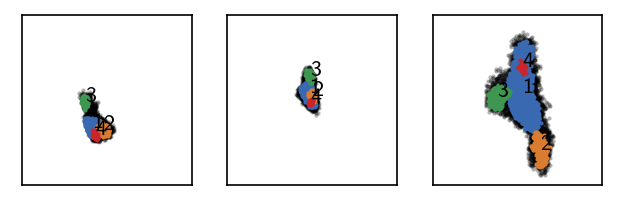

In [70]:
# Recluster first cluster from last step
current.data.points.cKDTree()  # We pre-compute neighbourhoods here
r = 0.19
current.calc_neighbours_from_cKDTree(r=r)
current.fit(r, 15, member_cutoff=10)
draw_evaluate(current)

### Merge hierarchy levels

We want to leave it with that for the moment. We can visualise our cluster hierarchy to get an overview. 

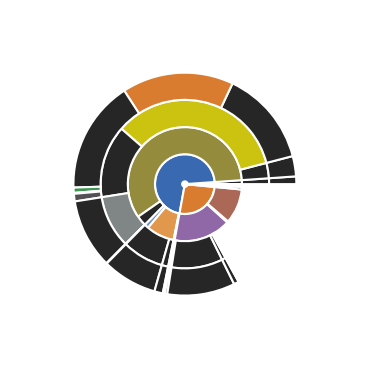

In [71]:
# Cluster hierarchy as pie diagram (hierarchy level increasing from the center outwards)
_ = langerin_reduced.pie()

And we can finally put everything together and incorporate the child clusters into the root data set.

In [72]:
# Deep=None goes done to the bottom of the hierarchy
langerin_reduced.reel(deep=None)

After this call, cluster labeling may not be contiguous and sorted by size, which we can fix easily.

In [73]:
langerin_reduced.labels.sort_by_size()

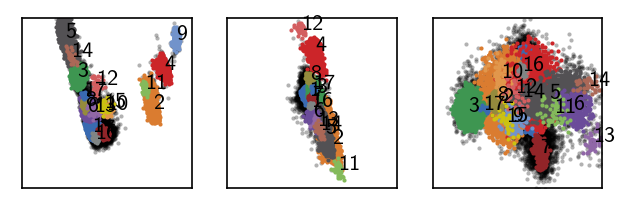

In [122]:
draw_evaluate(langerin_reduced)

In [121]:
print("Label    Size")
print("=============")
print(*sorted({k: len(v) for k, v in langerin_reduced.labels.clusterdict.items()}.items()), sep="\n")

Label    Size
(0, 9187)
(1, 4298)
(2, 4298)
(3, 2673)
(4, 2604)
(5, 2112)
(6, 324)
(7, 292)
(8, 204)
(9, 191)
(10, 72)
(11, 56)
(12, 44)
(13, 42)
(14, 40)
(15, 38)
(16, 35)
(17, 18)


For later re-use, we save the clustering result in form of the cluster label assignments.

In [144]:
# Save
np.save("md_example/cluster_labels.npy", langerin_reduced.labels)

In [25]:
# Read
labels = np.load("md_example/cluster_labels.npy")

In [33]:
import copy

In [83]:
backup = copy.deepcopy(langerin_reduced.labels)

In [126]:
langerin_reduced._labels = backup

In [109]:
langerin_reduced.labels.trash([6, 8])

In [125]:
backup.info

LabelInfo(origin='reeled', reference=CNN clustering object (root), params={15: (0.5, 5), 10: (0.5, 5), 12: (0.5, 5), 11: (0.5, 5), 9: (0.5, 5), 6: (0.375, 10), 5: (0.375, 10), 14: (0.375, 10), 13: (0.375, 10), 3: (0.25, 15), 17: (0.25, 15), 1: (0.19, 15), 8: (0.19, 15), 16: (0.19, 15), 7: (0.19, 15), 2: (0.4, 5), 4: (0.4, 5)})

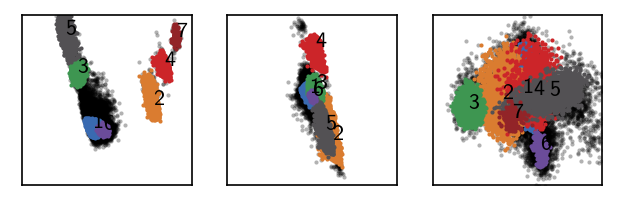

In [110]:
draw_evaluate(langerin_reduced)

In [35]:
backup

Labels([1, 1, 1, ..., 3, 3, 0])

### MSM estimation

Assuming our data was sampled in a time-correlated manner as it is the case for MD simulation data, we can use this clustering result as a basis for the estimation of a core-set Markov-state model.

In [130]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [131]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5, v=False)
    M.get_its()

[(0.0, 2000.0)]

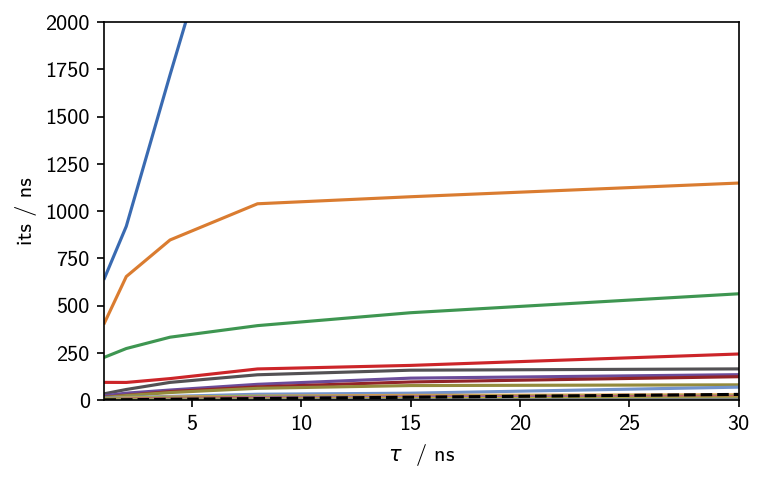

In [132]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)
ax.set(**{
    "ylim": (0, 2000)
})

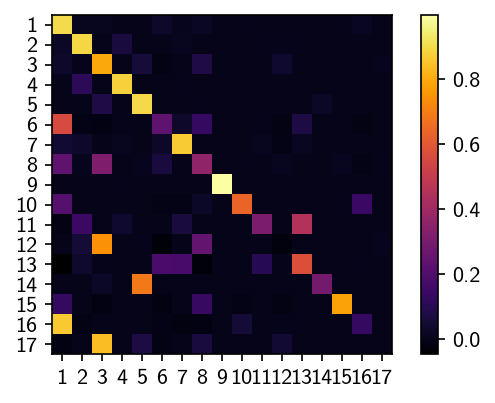

In [133]:
fig, ax = plt.subplots()
matrix = ax.imshow(M.T, cmap=mpl.cm.inferno)
fig.colorbar(matrix)
ax.set(**{
    "aspect": "equal",
    "xticks": range(len(M.T)),
    "xticklabels": range(1, len(M.T) + 1),
    "yticks": range(len(M.T)),
    "yticklabels": range(1, len(M.T) + 1)
})
plt.show()

## Prediction

In [134]:
# Lets make sure we work on the correctly clustered object
print("Label", "r", "c", sep="\t")
print("-" * 20)
for k, v in sorted(langerin_reduced.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	c
--------------------
1	0.19	15
2	0.4	5
3	0.25	15
4	0.4	5
5	0.375	10
6	0.375	10
7	0.19	15
8	0.19	15
9	0.5	5
10	0.5	5
11	0.5	5
12	0.5	5
13	0.375	10
14	0.375	10
15	0.5	5
16	0.19	15
17	0.25	15


In [142]:
langerin_reduced_less = langerin.cut(points=(None, None, 50))

In [143]:
langerin_reduced_less.calc_dist(langerin_reduced, mmap=True, mmap_file="/home/janjoswig/tmp/tmp.npy", chunksize=1000)  # Distance map calculation

MemoryError: Unable to allocate 10.5 GiB for an array with shape (52942, 26528) and data type float64

## Cluster alternatives

It is always recommended to cross validate a clustering result with the outcome of other clustering approaches. We want to have a quick look at the alternative that density-peak clustering provides.

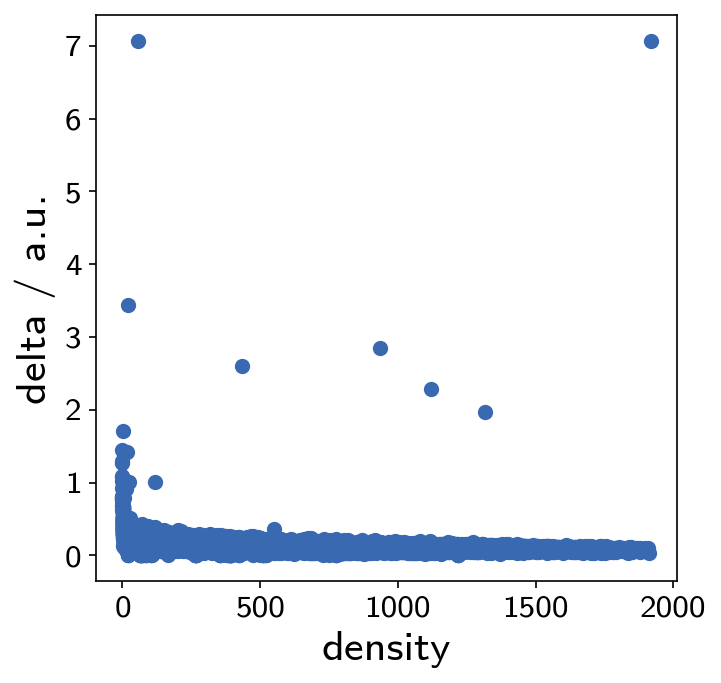

In [61]:
pydpc_clustering = pydpc.Cluster(langerin_reduced.data.points)

Clustering in this case is just a single step without the need of parameter specification. In the following, however, we need to extract the actual clusters by looking at the plot below. Points that are clearly isolated in this plot are highly reliable cluster centers.

In [65]:
pydpc_clustering.autoplot = True

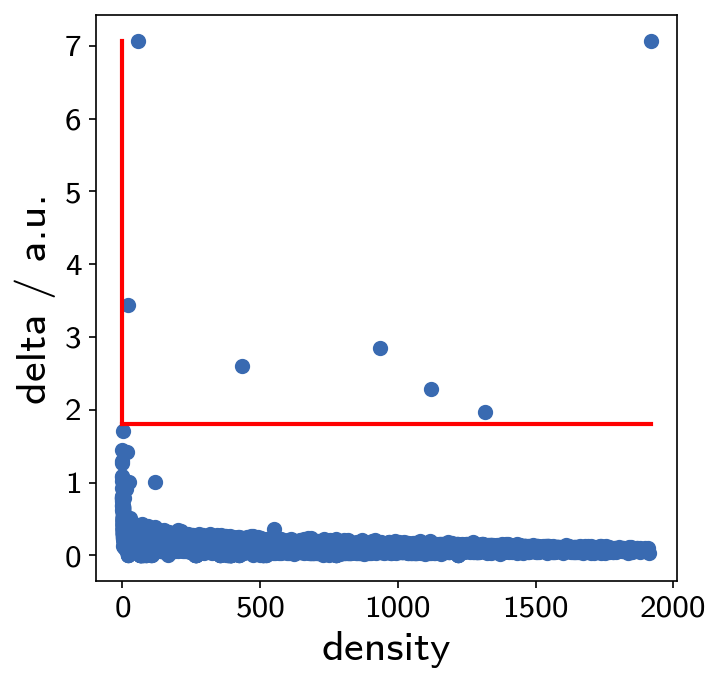

In [66]:
pydpc_clustering.assign(0, 1.8)

This gives us 7 clusters.

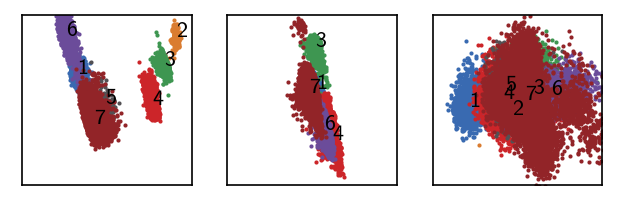

In [70]:
langerin_reduced.labels = (pydpc_clustering.membership + 1)
draw_evaluate(langerin_reduced)

As we are interested in core clusters we want to apply the core/halo criterion to disregard points with low cluster membership probabilitie as noise.

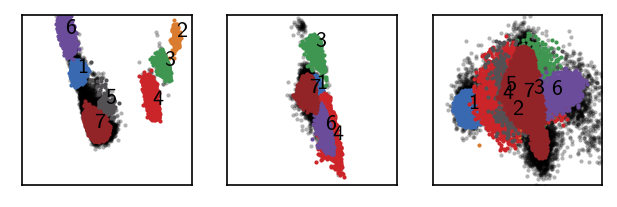

In [71]:
langerin_reduced.labels[pydpc_clustering.halo_idx] = 0
draw_evaluate(langerin_reduced)

In [72]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [73]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 4 ns
-----------------------

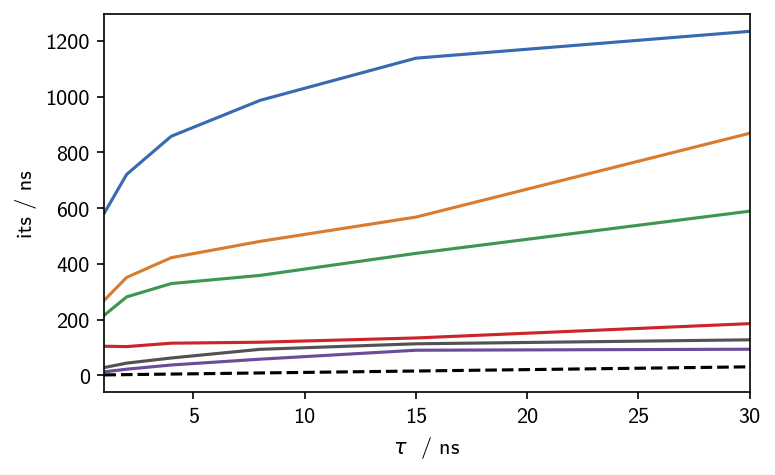

In [74]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

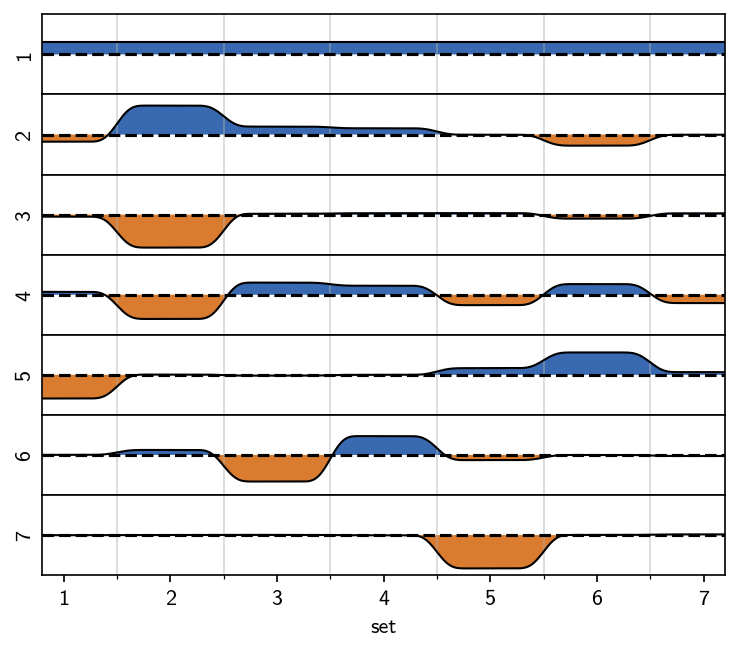

In [75]:
figsize = mpl.rcParams["figure.figsize"]
mpl.rcParams["figure.figsize"] = figsize[0], figsize[1] * 0.2
M.plot_eigenvectors()
mpl.rcParams["figure.figsize"] = figsize

This result is in good agreement with the one we obtained manually and argualbe faster and easier to achieve. If we decide that this result is exactly what we consider valid, then this is nice. If we on the other hand want to tune the clustering result further, with respect to splitting, noise level and what is considered noise in the first place we gain more flexibility with the manual approach.